In [218]:
import numpy as np
from env.single_state_env import SingleStateEnvironment
from utils.reward_func import inverse_reward_func, diversity_reward_function, more_cell_reward_func
from utils.score_func import relevance_score_func
from utils.helper import load_dictionary, action2elec_amp
from agent.epsilon_greedy import EpsilonGreedyAgent
from agent.sarsa_agent import SARSAAgent
from agent.ucb1_agent import UCB1Agent
from agent.sarsa_ucb1_agent import SARSAUCB1Agent
from tqdm import tqdm
import matplotlib.pyplot as plt

In [219]:
N_ELECTRODES = 512
N_AMPLITUDES = 42
N_EXAUSTIVE_SEARCH = N_ELECTRODES * N_AMPLITUDES * 25

In [228]:
N_EXAUSTIVE_SEARCH

537600

In [217]:
(1/(N_AMPLITUDES*N_ELECTRODES))*100

0.004650297619047619

In [256]:
n_search=540001
log_freq=60000

In [297]:
score_func = relevance_score_func
reward_func = diversity_reward_function
experiments = ["2022-11-04-2", "2022-11-28-1"]
experiment = experiments[0]
path = f"./data/{experiment}/dictionary"
usage_path = f"/Volumes/Scratch/Users/ajphillips/gdm_streamed/{experiment}/estim" # TODO CHANGEME
usage_path = f"./data/{experiment}/estim"
agent_list = ["RandomAgent", "EpsilonGreedyAgent", "DecayEpsilonGreedyAgent", 
                "SARSAAgent", "UCB1Agent", "SARSAUCB1Agent"]
# data: (dict, elecs, amps, elec_map, cell_ids, usage)
data = load_dictionary(path, usage_path)

In [298]:
agent_list = ["RandomAgent"]

In [299]:
# calculate the span score of the dictionary
baseline_score = score_func(data[0], dict_hat_count=np.ones(N_ELECTRODES*N_AMPLITUDES)*25, relevance=data[-1])
print(f"score of the exhaustive dictionary: {baseline_score}")

score of the exhaustive dictionary: 12031225.0


In [302]:
# average the scores for multiple runs
avg_score_hist_list = []
n_avg_itr = 2

In [303]:
for agent_name in agent_list:
    print("\n========================================")
    print(f"Agent: {agent_name}")

    # keep track of the scores for multiple runs
    score_hist_list = []
    action_freq = np.zeros((N_ELECTRODES*N_AMPLITUDES), dtype=np.uint64)
    for avg_itr in range(n_avg_itr):
        print(f"Average iteration: {avg_itr+1}/{n_avg_itr}")

        # initialize the environment
        env = SingleStateEnvironment(data, reward_func=reward_func, n_maxstep=N_EXAUSTIVE_SEARCH, 
                                        n_elecs=N_ELECTRODES, n_amps=N_AMPLITUDES)
        
        # initialize the agent
        if agent_name == "RandomAgent":
            agent = EpsilonGreedyAgent(env, gamma=0.9, epsilon=1.0, decay_rate=1, lr=0.1)
        elif agent_name == "EpsilonGreedyAgent":
            agent = EpsilonGreedyAgent(env, gamma=0.9, epsilon=0.6, decay_rate=1, lr=0.1)
        elif agent_name == "DecayEpsilonGreedyAgent":
            agent = EpsilonGreedyAgent(env, gamma=0.9, epsilon=1.0, decay_rate=1-10e-6, lr=0.1)
        elif agent_name == "SARSAAgent":
            agent = SARSAAgent(env, gamma=0.9, epsilon=0.4, lr=0.1)
        elif agent_name == "UCB1Agent":
            agent = UCB1Agent(env, gamma=0.9, c=1.0, lr=0.1)
        elif agent_name == "SARSAUCB1Agent":
            agent = SARSAUCB1Agent(env, gamma=0.9, c=1.0, lr=0.1)
        else:
            raise ValueError("Agent name not found")
        
        # keep track of the score
        score_hist = []

        avg_required = True

        # run the experiment
        for i in tqdm(range(n_search)):
            state = env.state
            if i % log_freq == 0:
                good_actions = np.nonzero(agent.Q[state])[0]
                # print(f"Number of good actions: {good_actions.shape}")
                approx_dict = env.get_est_dictionary()[good_actions,:]
                if len(approx_dict) == 0:
                    score_hist.append(0)
                else:
                    score_hist.append(score_func(approx_dict, dict_hat_count=env.dict_hat_count, relevance=data[-1]))

                if score_hist[-1] > baseline_score and avg_required:
                    print(f"Found a better dictionary at iteration {i} with score {score_hist[-1]}")
                    action_freq += env.dict_hat_count.copy()
                    histogram_avg = False
                    break
                if i == n_search - 1 and avg_required:
                    print(f"Did not find a better dictionary with score {score_hist[-1]}")
                    action_freq += env.dict_hat_count.copy()
                    histogram_avg = False
            action = agent.choose_action()
            next_state, reward, done = env.step(action2elec_amp(action, N_AMPLITUDES))
            agent.update(state, action, reward, next_state)

        score_hist_list.append(score_hist)

    avg_score_hist_list.append(np.mean(score_hist_list, axis=0))



Agent: RandomAgent
Average iteration: 1/2


100%|██████████| 500001/500001 [00:30<00:00, 16177.50it/s]


Did not find a better dictionary with score 11476233.0
Average iteration: 2/2


100%|██████████| 500001/500001 [00:30<00:00, 16620.03it/s]

Did not find a better dictionary with score 11463784.0


In [304]:
action_freq = action_freq / n_avg_itr

500000.0


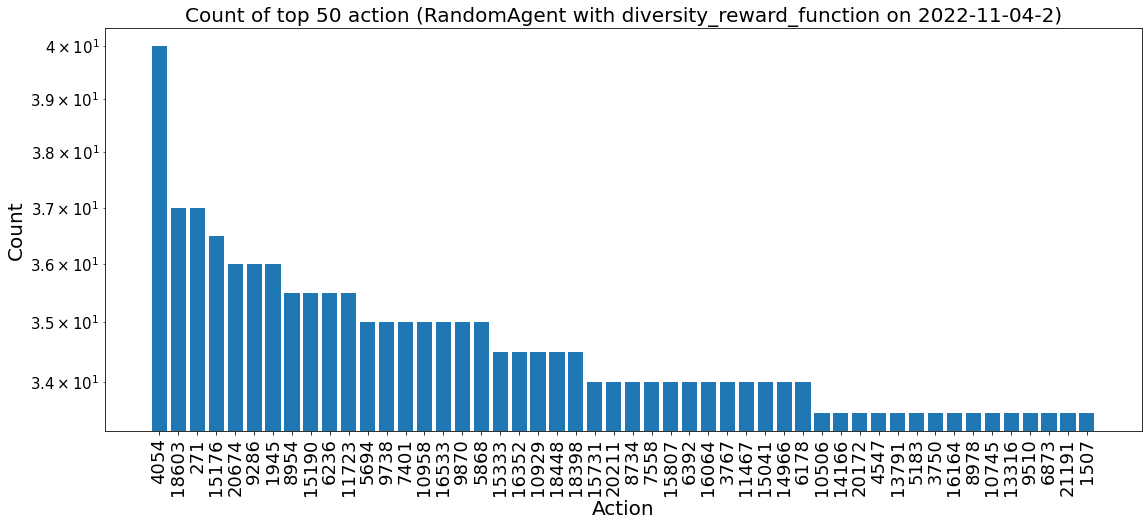

In [306]:
print(np.sum(action_freq))
x = 50
top_x = np.argsort(action_freq)[::-1][:x]
plt.figure(figsize=(18, 8))
plt.subplots_adjust(bottom=0.18, left=0.1, right=0.9)
plt.rcParams['font.size'] = 15
plt.bar(np.arange(x), action_freq[top_x])
# convert int element to str
top_x = [str(i) for i in top_x]
# add labels to each bar
plt.xticks(range(len(top_x)), top_x, rotation=90, fontsize=18)
plt.xlabel("Action", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.yscale("log")
plt.title(f"Count of top {x} action ({agent_name} with {reward_func.__name__} on {experiment})", fontsize=20)
plt.savefig(f"./assets/histograms/{experiment}_{agent_name}_{reward_func.__name__}_top_{x}_action_count.png", dpi=300, facecolor='w')
# plt.show()

100.0


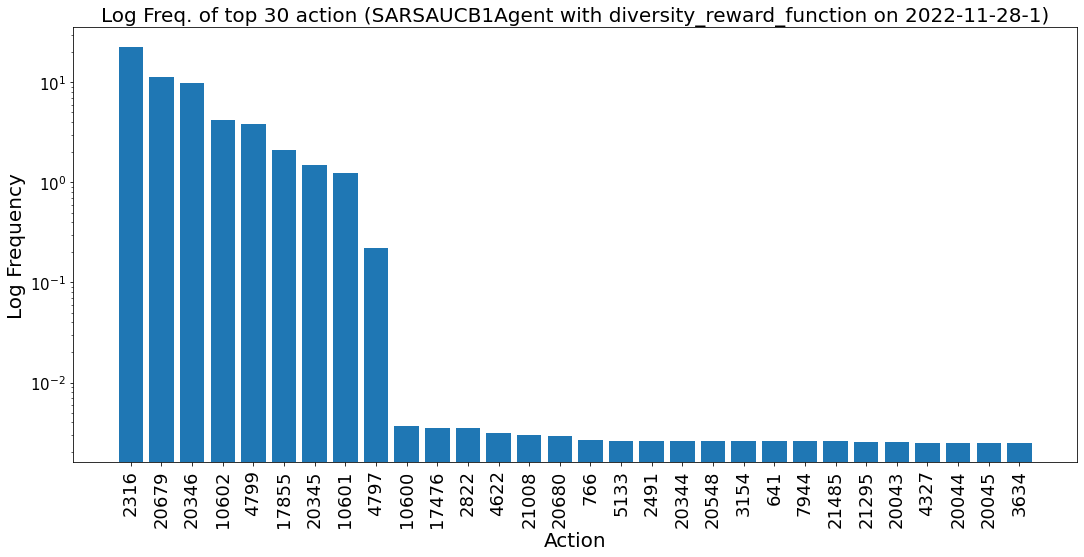

In [213]:
action_freq = action_freq / np.sum(action_freq) * 100
print(np.sum(action_freq))
x = 30
top_x = np.argsort(action_freq)[::-1][:x]
plt.figure(figsize=(18, 8))
plt.rcParams['font.size'] = 15
plt.bar(np.arange(x), action_freq[top_x])
# convert int element to str
top_x = [str(i) for i in top_x]
# add labels to each bar
plt.xticks(range(len(top_x)), top_x, rotation=90, fontsize=18)
plt.xlabel("Action", fontsize=20)
plt.ylabel("Log Frequency", fontsize=20)
plt.yscale("log")
plt.title(f"Log Freq. of top {x} action ({agent_name} with {reward_func.__name__} on {experiment})", fontsize=20)
plt.savefig(f"./assets/histograms/{experiment}_{agent_name}_{reward_func.__name__}_top_{x}_action_log_freq.png", dpi=300, facecolor='w')
# plt.show()

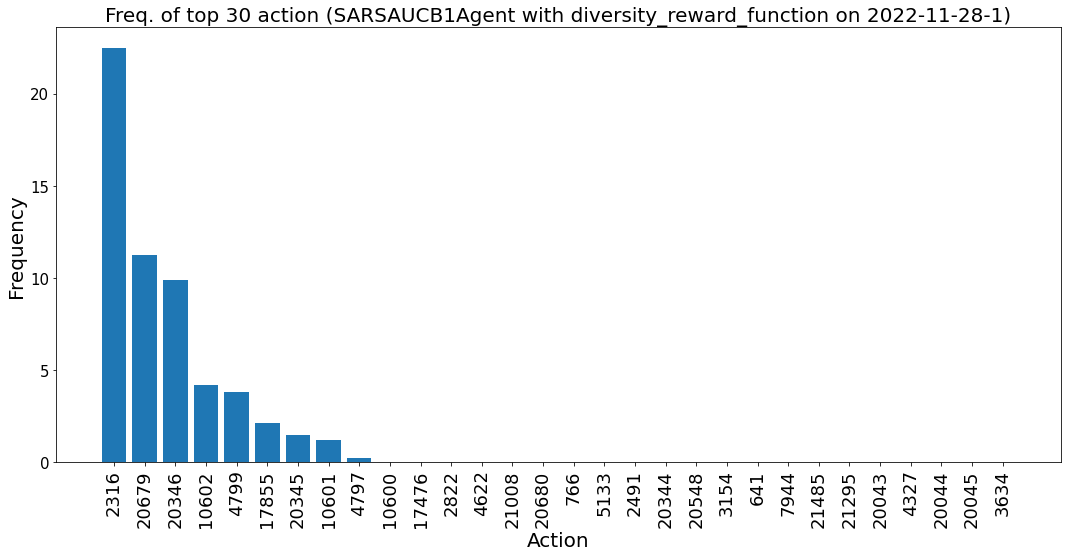

In [214]:
action_freq = action_freq / np.sum(action_freq) * 100
x = 30
top_x = np.argsort(action_freq)[::-1][:x]
plt.figure(figsize=(18, 8))
plt.rcParams['font.size'] = 15
plt.bar(np.arange(x), action_freq[top_x])
# convert int element to str
top_x = [str(i) for i in top_x]
# add labels to each bar
plt.xticks(range(len(top_x)), top_x, rotation=90, fontsize=18)
plt.xlabel("Action", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.title(f"Freq. of top {x} action ({agent_name} with {reward_func.__name__} on {experiment})", fontsize=20)
plt.savefig(f"./assets/histograms/{experiment}_{agent_name}_{reward_func.__name__}_top_{x}_action_freq.png", dpi=300, facecolor='w')
# plt.show()

In [ ]:
# plot the span scores for each agent in the same plot
fig, ax = plt.subplots()
for i, agent_name in enumerate(agent_list):
    ax.plot(avg_score_hist_list[i], label=agent_name)
ax.set_xlabel("Episode {0}k".format(log_freq/1000), fontsize=14)
ax.set_ylabel("Score", fontsize=14)
ax.set_title(f"Score_{experiment}_{reward_func.__name__}", fontsize=16)
ax.legend()
ax.axvline(x=N_EXAUSTIVE_SEARCH/log_freq, color="black", linestyle="--")
ax.axhline(y=baseline_score, color="black", linestyle="--")
fig.savefig(f"./assets/histograms/scores_{experiment}_{score_func.__name__}_{reward_func.__name__}_{n_search}_{n_avg_itr}.png", dpi=300)
plt.show()